In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from tqdm import tqdm 
import random
random.seed(56)

import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

import xgboost
import lightgbm
from sklearn import ensemble
import optuna

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

## Dataset

In [3]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [4]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [5]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### dtypes

In [6]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2871        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 2881, dtype: object

In [7]:
#train['LINE'] = train['LINE'].astype('category')
#train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')

### Y Class & Y Quality

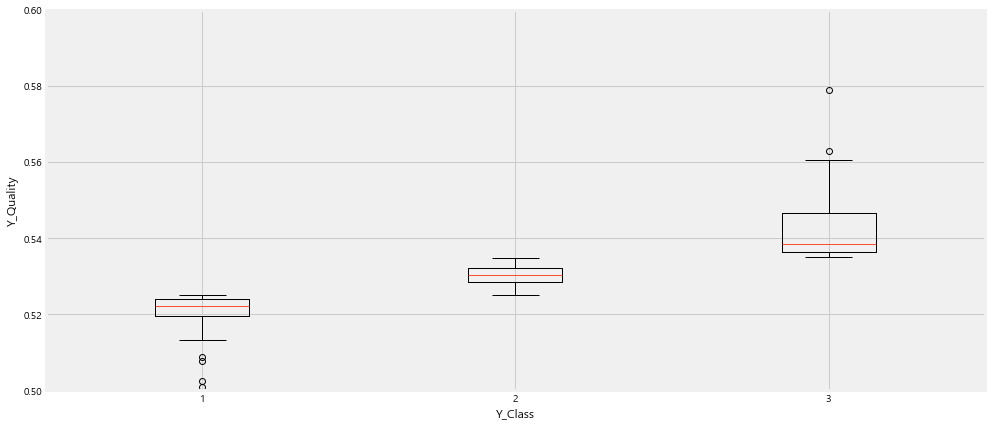

In [8]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [9]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [10]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code

In [11]:
# Product Code는 3가지로 이루어져 있다.
train['PRODUCT_CODE'].value_counts()

T_31    343
A_31    249
O_31      6
Name: PRODUCT_CODE, dtype: int64

### Line

In [12]:
# Line은 6가지
train['LINE'].value_counts()

T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: LINE, dtype: int64

### TimeStamp

* 일, 시, 분 단위 모두 연속적이지 않으므로 활용할 수 없다. interpolate(보간)을 하기에도 너무 공백이 많다.
* 단 월 단위는 quality의 감소세가 확인된다.

In [13]:
train.TIMESTAMP

0       2022-06-13 5:14
1       2022-06-13 5:22
2       2022-06-13 5:30
3       2022-06-13 5:39
4       2022-06-13 5:47
             ...       
593    2022-09-08 14:30
594    2022-09-08 22:38
595    2022-09-08 22:47
596    2022-09-08 14:38
597    2022-09-08 14:46
Name: TIMESTAMP, Length: 598, dtype: object

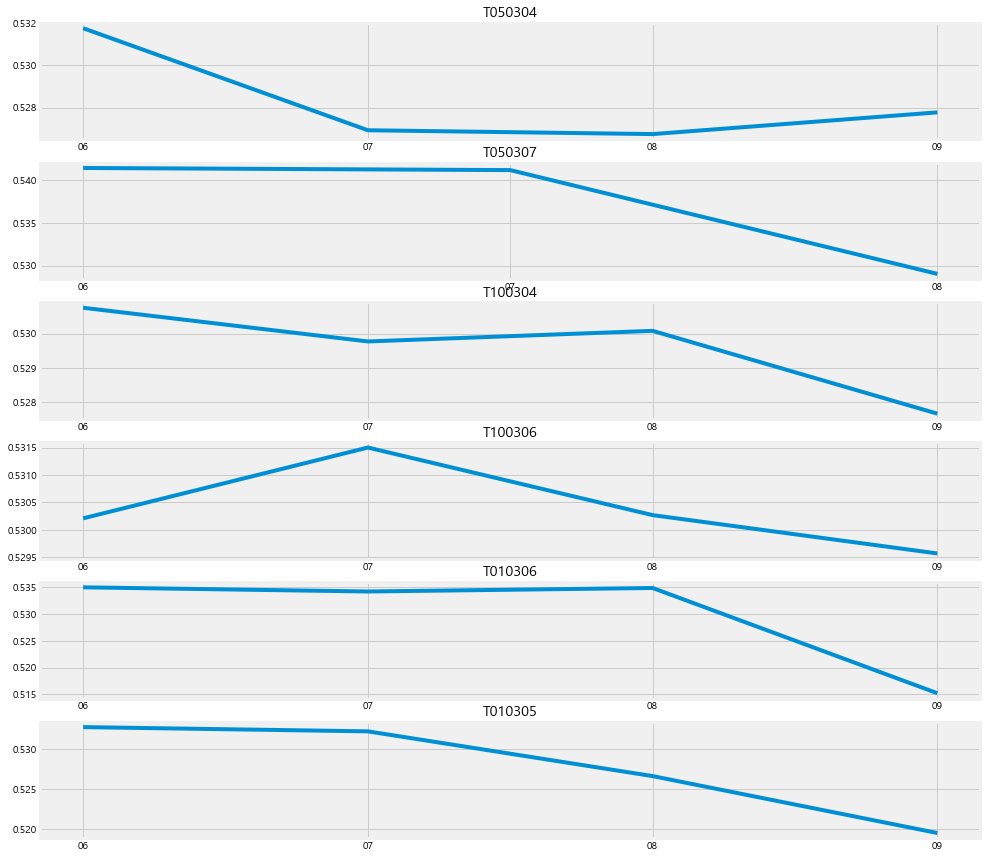

In [14]:
# LINE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

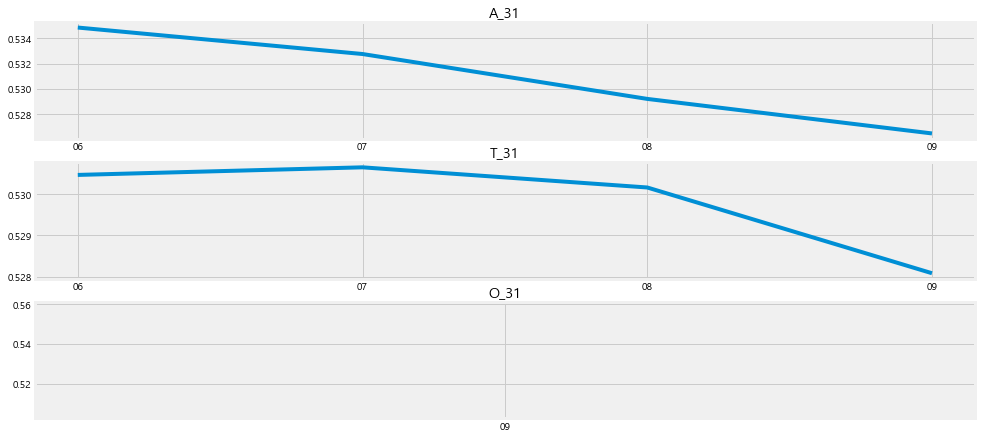

In [15]:
# PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train['PRODUCT_CODE'].unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

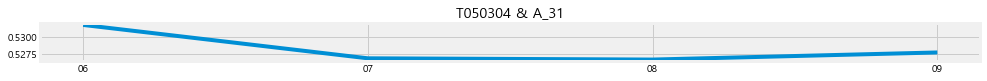

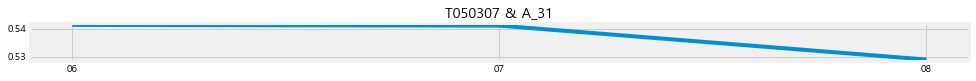

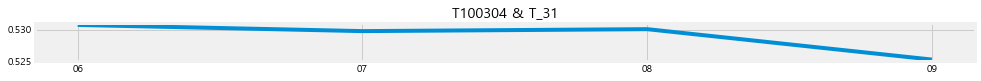

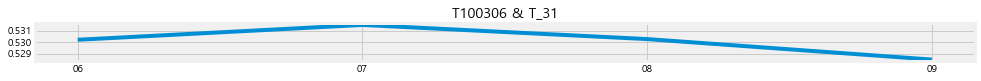

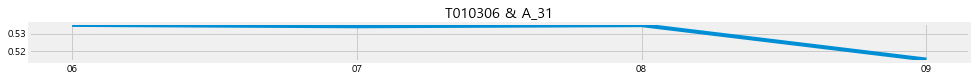

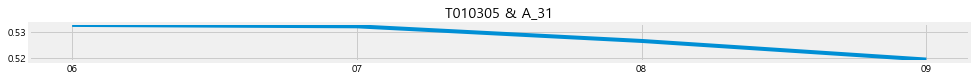

In [16]:
# LINE & PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    for i, c in enumerate(['A_31', 'T_31']): # O_31은 표본이 너무 적어 제외
        tmp = train[(train['PRODUCT_CODE']==c)&(train['LINE']==l)]
        if len(tmp) == 0: continue
        plt.subplot(len(train.LINE.unique())*len(train.PRODUCT_CODE.unique()), 1, i+1)
        tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
        tmp = tmp.groupby('TIMESTAMP').mean()
        plt.plot(tmp.index, tmp['Y_Quality'])
        plt.title(f'{l} & {c}')
    plt.show()

In [17]:
# 월별 영향력이 있어보인다.
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%m').astype('int64')
test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%m').astype('int64')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,6,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,6,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,6,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [18]:
len(train.columns)

2881

#### Product Code & Line에 따라 분류했을 경우

In [19]:
train_A1 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050304')]
train_A2 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050307')]
train_A3 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010306')]
train_A4 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010305')]
train_T1 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100304')]
train_T2 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100306')]
train_O1 = train[train['PRODUCT_CODE'] == 'O_31']

In [20]:
test_A1 = test[(test['PRODUCT_CODE'] == 'A_31') & (test['LINE'] == 'T050304')]
test_A2 = test[(test['PRODUCT_CODE'] == 'A_31') & (test['LINE'] == 'T050307')]
test_A3 = test[(test['PRODUCT_CODE'] == 'A_31') & (test['LINE'] == 'T010306')]
test_A4 = test[(test['PRODUCT_CODE'] == 'A_31') & (test['LINE'] == 'T010305')]
test_T1 = test[(test['PRODUCT_CODE'] == 'T_31') & (test['LINE'] == 'T100304')]
test_T2 = test[(test['PRODUCT_CODE'] == 'T_31') & (test['LINE'] == 'T100306')]
test_O1 = test[test['PRODUCT_CODE'] == 'O_31']

In [21]:
print(len(train_A1))
print(len(train_A2))
print(len(train_A3))
print(len(train_A4))
print(len(train_T1))
print(len(train_T2))
print(len(train_O1))

78
42
70
59
172
171
6


In [22]:
print(len(test_A1))
print(len(test_A2))
print(len(test_A3))
print(len(test_A4))
print(len(test_T1))
print(len(test_T2))
print(len(test_O1))

13
26
14
14
108
131
4


In [23]:
# 결측치가 5% 이상이면 제거
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if len(train_df[train_df[x].isnull()]) > len(train_df)*0.05 or len(test_df[test_df[x].isnull()]) > 0:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [24]:
train_A1, test_A1 = remove_col(train_A1, test_A1)
train_A2, test_A2 = remove_col(train_A2, test_A2)
train_A3, test_A3 = remove_col(train_A3, test_A3)
train_A4, test_A4 = remove_col(train_A4, test_A4)
train_T1, test_T1 = remove_col(train_T1, test_T1)
train_T2, test_T2 = remove_col(train_T2, test_T2)
train_O1, test_O1 = remove_col(train_O1, test_O1)

In [25]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

1444
1447
853
877
662
659
656


In [26]:
# 결측값 대체
def nan_replace(df):
    for x in df.columns[6:]:
        for i in df[df[x].isnull()].index:
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==df['TIMESTAMP'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]-1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]+1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue

            df[x][i] = np.mean(df[df['Y_Class']==df['Y_Class'][i]][x])
    return df

In [27]:
train_A1 = nan_replace(train_A1)
train_A2 = nan_replace(train_A2)
train_A3 = nan_replace(train_A3)
train_A4 = nan_replace(train_A4)
train_T1 = nan_replace(train_T1)
train_T2 = nan_replace(train_T2)
train_O1 = nan_replace(train_O1)

In [28]:
train_A1.reset_index(drop=True, inplace=True)
train_A2.reset_index(drop=True, inplace=True)
train_A3.reset_index(drop=True, inplace=True)
train_A4.reset_index(drop=True, inplace=True)
train_T1.reset_index(drop=True, inplace=True)
train_T2.reset_index(drop=True, inplace=True)
train_O1.reset_index(drop=True, inplace=True)

In [55]:
# 상관계수 0.95 이상이면 제거
def corr_drop(train_df):
    tmp = train_df[train_df.columns[6:]].corr()
    for e, c in enumerate(tmp.columns):
        for i in range(e+1, len(tmp.columns)):
            if abs(tmp[c][i]) >= 0.9 and tmp.columns[i] in train_df.columns:
                train_df.drop(columns=[tmp.columns[i]], inplace=True)
    return train_df

In [56]:
train_A1 = corr_drop(train_A1)
train_A2 = corr_drop(train_A2)
train_A3 = corr_drop(train_A3)
train_A4 = corr_drop(train_A4)
train_T1 = corr_drop(train_T1)
train_T2 = corr_drop(train_T2)
train_O1 = corr_drop(train_O1)

In [29]:
# nunique == 1 인 column 제거. ex) LINE, PRODUCT_CODE, x_??
def del_same_value(train_df):
    for c in train_df.columns:
        if train_df[c].nunique() == 1:
            train_df.drop(columns=[c], inplace=True)
    return train_df

In [30]:
train_A1 = del_same_value(train_A1)
train_A2 = del_same_value(train_A2)
train_A3 = del_same_value(train_A3)
train_A4 = del_same_value(train_A4)
train_T1 = del_same_value(train_T1)
train_T2 = del_same_value(train_T2)
train_O1 = del_same_value(train_O1)

In [31]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

1166
1194
698
720
527
530
496


In [63]:
train.fillna(0, inplace=True)
train = corr_drop(train)
train = del_same_value(train)

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

### Over Sampling

#### oversampling 이전, 전처리

In [32]:
train_A1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A3.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A4.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_O1.drop(columns=['LINE', 'PRODUCT_ID', 'Y_Quality'], inplace=True)
#train.drop(columns=['LINE', 'PRODUCT_ID', 'Y_Quality', 'PRODUCT_CODE'], inplace=True)

test_A1 = test_A1[train_A1.columns[1:]]
test_A2 = test_A2[train_A2.columns[1:]]
test_A3 = test_A3[train_A3.columns[1:]]
test_A4 = test_A4[train_A4.columns[1:]]
test_T1 = test_T1[train_T1.columns[1:]]
test_T2 = test_T2[train_T2.columns[1:]]
test_O1 = test_O1[train_O1.columns[1:]]

<AxesSubplot:xlabel='X_2', ylabel='X_18'>

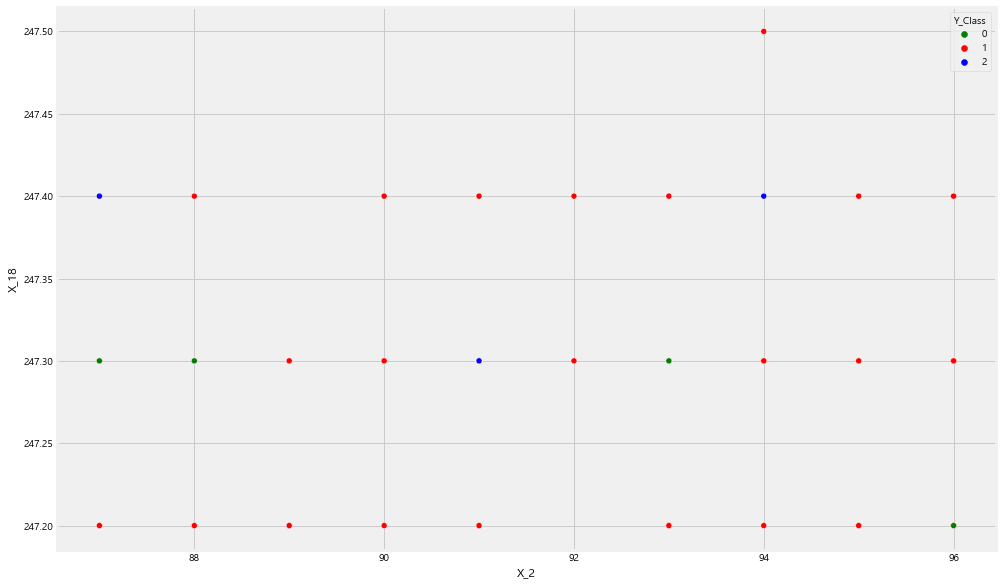

In [33]:
rcParams['figure.figsize'] = 15, 10
sns.scatterplot(data=train_T2, x='X_2', y='X_18', hue='Y_Class', palette=['green', 'red', 'blue'])

In [34]:
def Borderline_SMOTE(train_df):
    B_SMOTE = BorderlineSMOTE(random_state=0)
    x_b_smote, y_b_smote = B_SMOTE.fit_resample(train_df[train_df.columns[1:]], train_df['Y_Class'])
    train_df = x_b_smote
    train_df['Y_Class'] = y_b_smote
    
    return train_df

In [36]:
train_A1 = Borderline_SMOTE(train_A1)
train_A2 = Borderline_SMOTE(train_A2)
train_A3 = Borderline_SMOTE(train_A3)
train_A4 = Borderline_SMOTE(train_A4)
train_T1 = Borderline_SMOTE(train_T1)
train_T2 = Borderline_SMOTE(train_T2)
# train_O1 = Borderline_SMOTE(train_O1) # train_O1은 표본이 6개로 너무 적어서 smote를 이용할 수 없음

In [37]:
# def ADASYN_(train_df):
#     adasyn = ADASYN(random_state=0, sampling_strategy='minority')
#     x_adasyn, y_adasyn = adasyn.fit_resample(train_df[train_df.columns[1:]], train_df['Y_Class'])

#     train_df = x_adasyn
#     train_df['Y_Class'] = y_adasyn
#     return train_df

In [38]:
# train_A1 = ADASYN_(train_A1)
# train_A2 = ADASYN_(train_A2)
# train_A3 = ADASYN_(train_A3)
# train_A4 = ADASYN_(train_A4)
# train_T1 = ADASYN_(train_T1)
# train_T2 = ADASYN_(train_T2)

<AxesSubplot:xlabel='X_2', ylabel='X_18'>

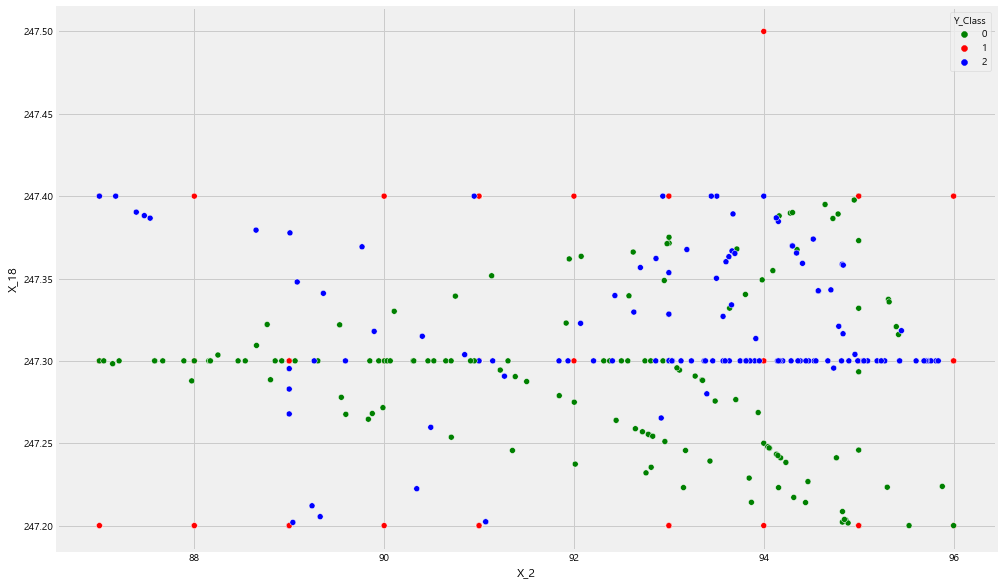

In [39]:
sns.scatterplot(data=train_T2, x='X_2', y='X_18', hue='Y_Class', palette=['green', 'red', 'blue'])

### Optuna

In [36]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'boost_from_average' : True
        }

    clf = lightgbm.LGBMClassifier(**params)
    
    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='micro'))    
    
    return np.mean(f1_list)

def rf_objective(trial):

    params = {
                'max_depth' : trial.suggest_int('max_depth', 1, 10),
                'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
                'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                "n_jobs": 4
        }

    clf = ensemble.RandomForestClassifier(**params)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))    

    return np.mean(f1_list)

def xgb_objective(trial):

    params = {
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                "n_jobs": 4,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),  
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
            }

    clf = xgboost.XGBClassifier(**params)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))    

    return np.mean(f1_list)

In [38]:
study_list = []
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306']]

for cl, train_df in tqdm(zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2])):
    
    # split
    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    # optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=10, show_progress_bar=True) # lgbm_objective, rf_objective, xgb_objective

    clear_output(wait=True)
    study_list.append(study)

3it [00:27,  9.07s/it][I 2023-02-11 23:01:23,498] A new study created in memory with name: no-name-cfb973d9-303d-4fc1-b441-ddba9c33ee35


  0%|          | 0/10 [00:00<?, ?it/s]

3it [00:28,  9.07s/it]

[I 2023-02-11 23:01:24,794] Trial 0 finished with value: 0.35376344086021505 and parameters: {'max_depth': 4, 'max_leaf_nodes': 551, 'n_estimators': 424}. Best is trial 0 with value: 0.35376344086021505.


3it [00:29,  9.07s/it]

[I 2023-02-11 23:01:25,794] Trial 1 finished with value: 0.3305874840357599 and parameters: {'max_depth': 9, 'max_leaf_nodes': 982, 'n_estimators': 326}. Best is trial 0 with value: 0.35376344086021505.


3it [00:30,  9.07s/it]

[I 2023-02-11 23:01:26,673] Trial 2 finished with value: 0.41139601139601134 and parameters: {'max_depth': 7, 'max_leaf_nodes': 641, 'n_estimators': 282}. Best is trial 2 with value: 0.41139601139601134.


3it [00:30,  9.07s/it]

[I 2023-02-11 23:01:27,250] Trial 3 finished with value: 0.42599798979727294 and parameters: {'max_depth': 9, 'max_leaf_nodes': 187, 'n_estimators': 180}. Best is trial 3 with value: 0.42599798979727294.


3it [00:31,  9.07s/it]

[I 2023-02-11 23:01:27,601] Trial 4 finished with value: 0.26688723462917013 and parameters: {'max_depth': 3, 'max_leaf_nodes': 647, 'n_estimators': 102}. Best is trial 3 with value: 0.42599798979727294.


3it [00:32,  9.07s/it]

[I 2023-02-11 23:01:29,066] Trial 5 finished with value: 0.2482078853046595 and parameters: {'max_depth': 1, 'max_leaf_nodes': 942, 'n_estimators': 481}. Best is trial 3 with value: 0.42599798979727294.


3it [00:33, 11.17s/it]

[I 2023-02-11 23:01:29,777] Trial 6 finished with value: 0.30663082437275985 and parameters: {'max_depth': 2, 'max_leaf_nodes': 987, 'n_estimators': 224}. Best is trial 3 with value: 0.42599798979727294.


KeyboardInterrupt: 

In [65]:
def lgbm_objective_O_31(trial):

    params = {
            #"objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    clf = lightgbm.LGBMClassifier(**params)
    clf.fit(x_train, y_train)

    return f1_score(clf.predict(x_train), y_train, average='macro')

def rf_objective_O_31(trial):

    params = {
                'max_depth' : trial.suggest_int('max_depth', 1, 10),
                'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
                'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                "n_jobs": 4
        }

    clf = ensemble.RandomForestClassifier(**params)
    clf.fit(x_train, y_train)

    return f1_score(clf.predict(x_train), y_train, average='micro')

def xgb_objective_O_31(trial):

    params = {
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                "n_jobs": 4,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),  
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
            }

    clf = xgboost.XGBClassifier(**params) 
    clf.fit(x_train, y_train)

    return f1_score(clf.predict(x_train), y_train, average='macro')

x_train = train.drop(columns=['Y_Class'])
y_train = train['Y_Class']

study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective_O_31, n_trials=5, show_progress_bar=True) # lgbm_objective_O_31, rf_objective_O_31, xgb_objective_O_31

clear_output(wait=True)
study_list.append(study)

[I 2023-02-08 20:17:11,946] A new study created in memory with name: no-name-5ed25f7c-3ba0-4e35-9335-cf637929df73


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-02-08 20:17:23,528] Trial 0 finished with value: 0.7744453426952758 and parameters: {'max_depth': 10, 'learning_rate': 0.13061469685012445, 'n_estimators': 4000, 'colsample_bytree': 0.8371319032137579, 'colsample_bylevel': 0.7471740242970946, 'colsample_bynode': 0.625740700136949, 'reg_lambda': 0.8365178277281867, 'reg_alpha': 0.15016130801227268, 'min_child_weight': 14, 'gamma': 0.6470826901409845}. Best is trial 0 with value: 0.7744453426952758.
[I 2023-02-08 20:17:33,083] Trial 1 finished with value: 0.7885423753168578 and parameters: {'max_depth': 13, 'learning_rate': 0.24097950694755868, 'n_estimators': 3300, 'colsample_bytree': 0.8750001485671066, 'colsample_bylevel': 0.5619988852188844, 'colsample_bynode': 0.9437938367008715, 'reg_lambda': 0.020264019611394585, 'reg_alpha': 0.11863253889554139, 'min_child_weight': 11, 'gamma': 0.7701142067397966}. Best is trial 1 with value: 0.7885423753168578.
[I 2023-02-08 20:17:41,374] Trial 2 finished with value: 0.7411168596534449 a

In [66]:
print('k=3 cv-lgbm-optuna result')
f1_list = []

for study in study_list:
    trial = study.best_trial

    print("  f1_score : {}".format(trial.value))
    f1_list.append(trial.value)
#    print("  Best hyperparameters: ")
#    for key, value in trial.params.items():
#        print("    {}: {}".format(key, value))
print()
print(f'mean_f1 : {np.mean(f1_list)}')

k=3 cv-lgbm-optuna result
  f1_score : 0.8733345184069822
  f1_score : 0.9851851851851853
  f1_score : 0.8461823361823363
  f1_score : 0.8336055994179564
  f1_score : 0.9624625097646077
  f1_score : 0.9860945056500507
  f1_score : 0.9549192708778637

mean_f1 : 0.9202548464978547


In [ ]:
#optuna.visualization.plot_optimization_history(study_list[0])

In [68]:
print('predict train data')
f1_list = []
for train_df, study in zip([train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train], study_list):
    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(x_train, y_train)
    f1 = f1_score(clf.predict(x_train), y_train, average='macro')
    f1_list.append(f1)
    print(f1)
print()
print(np.mean(f1_list))

predict train data
1.0
1.0
1.0
1.0
1.0
1.0
1.0

1.0


In [69]:
for study in study_list:
    print(study.best_params)
    print()
    
param_list = []
train_list = [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1]
test_list = [test_A1, test_A2, test_A3, test_A4, test_T1, test_T2, test_O1]
for cl, train_df, test_df, study in zip(code_line, train_list, test_list, study_list):

    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']

    # model
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(x_train, y_train)
    pred = clf.predict(test_df)
    for i, idx in enumerate(test_df.index):
        subm['Y_Class'][idx] = pred[i]


{'max_depth': 6, 'learning_rate': 0.17422563438458344, 'n_estimators': 3900, 'colsample_bytree': 0.7622697697327729, 'colsample_bylevel': 0.6148332165214436, 'colsample_bynode': 0.5000615694754943, 'reg_lambda': 0.015095790960676293, 'reg_alpha': 0.011921704706996016, 'min_child_weight': 5, 'gamma': 0.1951990683599238}

{'max_depth': 10, 'learning_rate': 0.24082767448791664, 'n_estimators': 4900, 'colsample_bytree': 0.6307174317581732, 'colsample_bylevel': 0.5668407760106493, 'colsample_bynode': 0.9983013638404321, 'reg_lambda': 0.05281422185893874, 'reg_alpha': 0.03782752473016584, 'min_child_weight': 5, 'gamma': 0.15776247281948969}

{'max_depth': 7, 'learning_rate': 0.44069166275592325, 'n_estimators': 10000, 'colsample_bytree': 0.8938243217140287, 'colsample_bylevel': 0.7249811883511911, 'colsample_bynode': 0.6357294378529655, 'reg_lambda': 0.08127761352559235, 'reg_alpha': 0.1292593103218399, 'min_child_weight': 9, 'gamma': 0.44578111325504943}

{'max_depth': 5, 'learning_rate': 0

In [75]:
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306'], ['O_31']]
for cl, train_df, study in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train], study_list):

    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    if cl[0] == 'O_31':
        test_cl = test[test['PRODUCT_CODE'] == cl[0]]
        test_cl = test_cl[train_df.columns[1:]]
        test_cl.fillna(0, inplace=True)
    else:
        test_cl = test[(test['PRODUCT_CODE'] == cl[0]) & (test['LINE'] == cl[1])]
    
    if len(test_cl) == 0:
        continue
    test_cl = test_cl[x_train.columns]
    
    # lightgbm
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(x_train, y_train)
    pred = clf.predict(test_cl)
    for i, idx in enumerate(test_cl.index):
        subm['Y_Class'][idx] = pred[i]

In [76]:
subm.Y_Class.value_counts()

1    260
2     28
0     22
Name: Y_Class, dtype: int64

In [77]:
subm.to_csv('submission/submission26.csv', index=False) # xgb

In [ ]:
## train test split 활용 -> cv말고 양분해서 진행
## 딥러닝도 해봐야할듯?
## regression 모델로 quality 예측 후 class select